In [59]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour, year, unix_timestamp, col, udf
from pyspark.sql.types import DoubleType, IntegerType, TimestampType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import math

In [60]:
spark = SparkSession.builder \
    .appName("Taxi Fare Prediction") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "2") \
    .config("spark.driver.maxResultSize", "1g") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "100s") \
    .getOrCreate()


In [61]:

csv_files_path = "hdfs://localhost:9000/Bigdata/*.csv"
combined_df = spark.read.csv(csv_files_path, header=True, inferSchema=True)


In [62]:
combined_df.count()

73050975

In [63]:
combined_df = combined_df.withColumn("passenger_count", combined_df["passenger_count"].cast(IntegerType())) \
    .withColumn("trip_distance", combined_df["trip_distance"].cast(DoubleType())) \
    .withColumn("pickup_longitude", combined_df["pickup_longitude"].cast(DoubleType())) \
    .withColumn("pickup_latitude", combined_df["pickup_latitude"].cast(DoubleType())) \
    .withColumn("dropoff_longitude", combined_df["dropoff_longitude"].cast(DoubleType())) \
    .withColumn("dropoff_latitude", combined_df["dropoff_latitude"].cast(DoubleType())) \
    .withColumn("fare_amount", combined_df["fare_amount"].cast(DoubleType())) \
    .withColumn("tpep_pickup_datetime", combined_df["tpep_pickup_datetime"].cast(TimestampType())) \
    .withColumn("tpep_dropoff_datetime", combined_df["tpep_dropoff_datetime"].cast(TimestampType()))


In [64]:
from pyspark.sql.functions import month, year

# Thêm cột month và year
combined_df = combined_df.withColumn("month", month("tpep_pickup_datetime")) \
                         .withColumn("year", year("tpep_pickup_datetime"))
jan_2015_df = combined_df.filter((combined_df["month"] == 1) & (combined_df["year"] == 2015))
jan_2015_filtered_df = jan_2015_df.filter(jan_2015_df["pickup_latitude"] < 100)


In [65]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
# Tạo VectorAssembler
vector_assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="features")
jan_2015_filtered_df = vector_assembler.transform(jan_2015_filtered_df)

# Xác định số cụm
num_clusters = 3  # Bạn có thể thay đổi hoặc sử dụng phương pháp Elbow để tìm k tốt nhất


In [67]:

# Áp dụng K-Means
kmeans = KMeans(k=num_clusters, seed=1)  # seed để đảm bảo tính nhất quán khi chạy lại
model = kmeans.fit(jan_2015_filtered_df.select("features"))  # Huấn luyện mô hình K-Means
clustered_df = model.transform(jan_2015_filtered_df)  # Phân cụm các điểm dữ liệu


C:\Users\35351\PycharmProjects\pythonProject\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


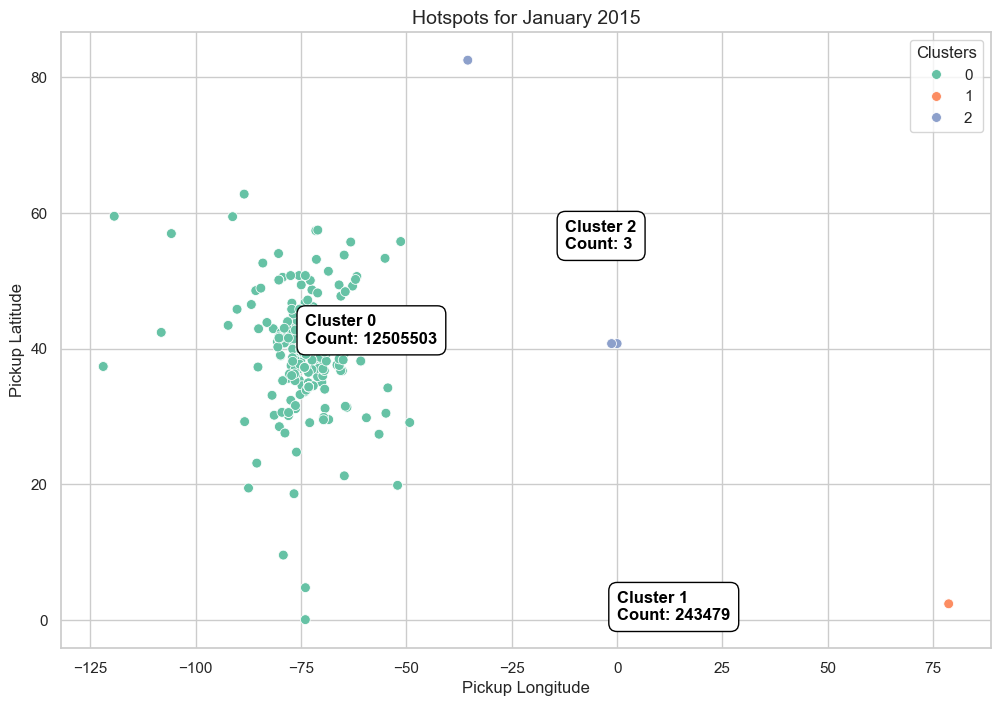

In [75]:
# Lấy kết quả phân cụm và chuyển đổi sang Pandas
predicted_df = clustered_df.select("pickup_longitude", "pickup_latitude", "prediction").toPandas()
centroids = model.clusterCenters()

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))

# Giảm kích thước điểm nếu cần để tránh trùng lặp
sns.scatterplot(x="pickup_longitude", y="pickup_latitude", hue="prediction", data=predicted_df, palette="Set2", s=50)

# Đếm số lượng điểm trong mỗi cụm
cluster_counts = predicted_df['prediction'].value_counts()

# Thêm chú thích số lượng giao dịch vào biểu đồ
for i, center in enumerate(centroids):
    plt.text(center[0], center[1], f'Cluster {i}\nCount: {cluster_counts[i]}', 
             fontsize=12, color='black', weight='bold', 
             bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# Thêm tiêu đề và nhãn
plt.title(f"Hotspots for January 2015", fontsize=14)
plt.xlabel("Pickup Longitude")
plt.ylabel("Pickup Latitude")
plt.grid(True)
plt.legend(title='Clusters')
plt.show()


In [1]:
spark.stop()

NameError: name 'spark' is not defined